In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy
import os
import xarray as xr
import pandas as pd
from scipy.interpolate import interp1d
import cartopy.crs as ccrs

import cartopy.feature as cfeature
import pickle

import matplotlib.image as mpimg

In [21]:
with open('s1_stack_best.pkl', 'rb') as f:
    s1_stack = pickle.load(f)

time_array_insar = s1_stack.time.values[:-1]

In [22]:
filename_A = "As_preprocessed_best.pkl"

filename_ls_phase = "ls_phase_arr_preprocesseds_best.pkl"

filename_phase_uw = "arc_phase_uw_preprocesseds_best.pkl"

filename_points = "points_preprocesseds_best.pkl"

filename_arcs = "arcs_preprocesseds_best.pkl"

with open(filename_A, "rb") as f:
    A = pickle.load(f)

with open(filename_ls_phase, "rb") as f:
    ls_phase = pickle.load(f)

with open(filename_phase_uw, "rb") as f:
    phase_uw = pickle.load(f)

with open(filename_points, "rb") as f:
    points = pickle.load(f)

with open(filename_arcs, "rb") as f:
    arcs = pickle.load(f)

In [23]:
A = A[0][0]
ls_phase = ls_phase[0][0]
phase_uw = phase_uw[0][0]
points = points[0][0]
arcs = arcs[0][0]

In [24]:
arcs.shape

(3121, 2)

In [25]:
def compute_MSE(A, ls_phase_arr, arc_phase_uw_uw):
    y_hat = A @ ls_phase_arr
    y_hat = y_hat[1:]

    residuals = arc_phase_uw_uw - y_hat

    mse = np.mean(residuals**2, axis=0)

    return mse

In [26]:
def compute_arc_deformation_mm(arc_phase_uw):
    c = 299_792_458
    freq = 5.404*10**9

    lam_meters = c / freq
    
    wavelength = lam_meters * 10**3 # mm


    arc_deformation = wavelength * arc_phase_uw / 4 / math.pi
    
    return arc_deformation

ls_deformation = compute_arc_deformation_mm(ls_phase)
arc_deformation = compute_arc_deformation_mm(phase_uw)

In [27]:
MSE_deformation = compute_MSE(A, ls_deformation, arc_deformation)

In [28]:
np.where(MSE_deformation > 0.5)[0]

array([], dtype=int64)

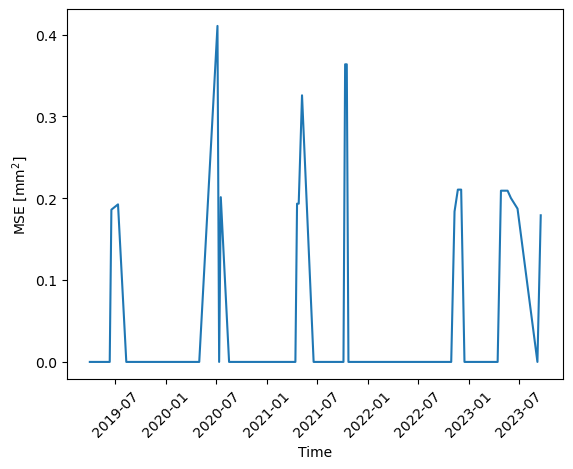

In [29]:
plt.plot(time_array_insar, MSE_deformation)
plt.ylabel("MSE [mm$^2$]")
plt.xlabel("Time")
plt.xticks(rotation=45)
plt.show()

In [30]:
min_sum = 1e8

for i, deform in enumerate(ls_deformation):
    if np.sum(np.abs(deform)) < min_sum:
        min_sum = np.sum(np.abs(deform))
        min_deform = deform
        ii = i

print(ii)

11


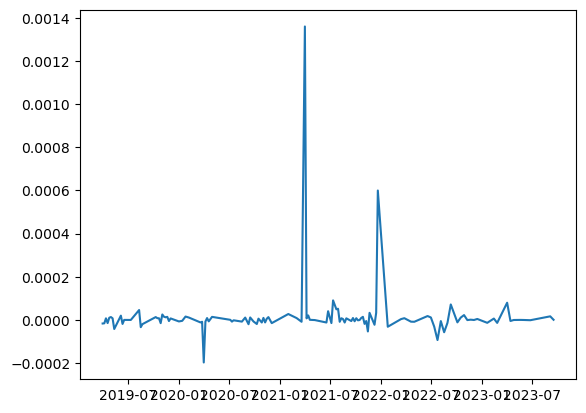

In [31]:
plt.plot(time_array_insar, min_deform)

In [32]:
# plt.plot(time_array_insar, deformation)

In [33]:
stm = scipy.io.loadmat('../06gps_nam_2006-2024.mat')

In [34]:
pntName=stm['pntName']
pntCrd=stm['pntCrd']
epochDyear=stm['epochDyear'][0]
obsTypes=stm['obsTypes']

obsData=stm['obsData']

In [79]:
pntList= [ pntName[x][0][0] for x in np.arange(0,pntName.shape[0]) ]
obsList= [ obsTypes[0][x][0] for x in np.arange(0,obsTypes.shape[1]) ]

pnum=pntList.index('RDN1')
updisplacements=obsData[pnum,:,2]
northdisplacements=obsData[pnum,:,0]
eastdisplacements=obsData[pnum,:,1]
print(epochDyear)

pnum_norg = pntList.index('NOR3')
updisplacements_norg=obsData[pnum_norg,:,2]
northdisplacements_norg=obsData[pnum_norg,:,0]
eastdisplacements_norg=obsData[pnum_norg,:,1]

[2006.40109514 2006.40383299 2006.40657084 ... 2024.00821355 2024.0109514
 2024.01368925]


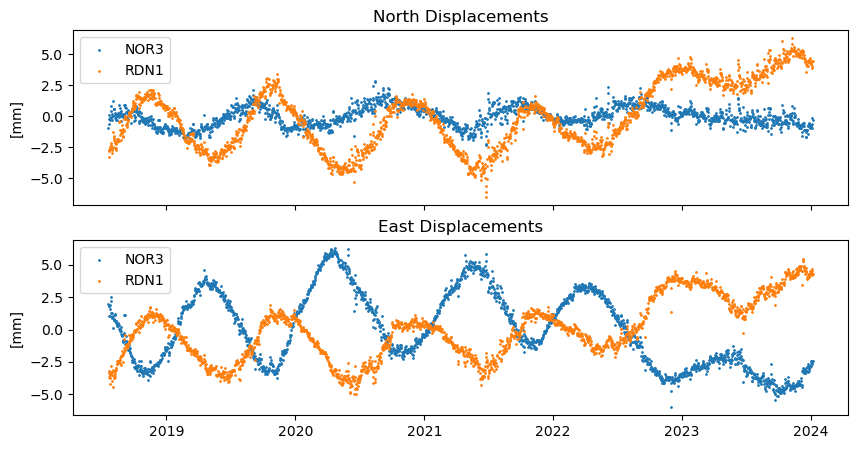

In [94]:
fig, axs = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

axs = axs.ravel()

axs[0].scatter(epochDyear, northdisplacements_norg, label="NOR3", s=1)
axs[0].scatter(epochDyear, northdisplacements, label="RDN1", s=1)

axs[1].scatter(epochDyear, eastdisplacements_norg, label="NOR3", s=1)
axs[1].scatter(epochDyear, eastdisplacements, label="RDN1", s=1)

axs[0].set_ylabel("[mm]")
axs[1].set_ylabel("[mm]")

axs[0].set_title("North Displacements")
axs[1].set_title("East Displacements")

axs[0].legend()
axs[1].legend()

plt.savefig("figures/horizontal_displacements.png", dpi=300, bbox_inches='tight')


plt.show()


In [36]:
def convert_datetime_to_decimal_year(datetime_array):
    """Convert an array of datetime strings to decimal year format using pandas."""
    dates = pd.to_datetime(datetime_array)
    year = dates.year
    day_of_year = dates.dayofyear
    is_leap_year = year % 4 == 0
    days_in_year = 366 * is_leap_year + 365 * (~is_leap_year)
    return year + (day_of_year - 1) / days_in_year

def interpolate_to_match_dates(source_dates, target_dates, source_values):
    """Interpolate source values to align with target dates."""
    interpolator = interp1d(source_dates, source_values, kind='nearest', fill_value="extrapolate")
    return interpolator(target_dates)

# Convert time_array_insar to decimal years using the adjusted function
time_array_decimal = convert_datetime_to_decimal_year(time_array_insar)

# Interpolate epochDyear values to match the converted time_array_insar dates
interpolated_values_east = interpolate_to_match_dates(epochDyear, time_array_decimal, eastdisplacements)
interpolated_values_north = interpolate_to_match_dates(epochDyear, time_array_decimal, northdisplacements)

In [41]:
interpolated_values_up = interpolate_to_match_dates(epochDyear, time_array_decimal, updisplacements)
def fill_nan_with_interpolation(arr):
    # Find indices where values are NaN
    nans = np.isnan(arr)
    
    # Find indices where values are not NaN
    not_nans = np.logical_not(nans)
    
    # Perform linear interpolation
    arr[nans] = np.interp(np.flatnonzero(nans), np.flatnonzero(not_nans), arr[not_nans])
    
    return arr

interpolated_values_up = fill_nan_with_interpolation(interpolated_values_up)


In [42]:
def get_vertical(lof, omega):
    """
    Computes the vertical deformation.

    Parameters:
    lof (float or np.array): The line-of-sight deformation.
    omega (float): The incidence angle (in radians).
    alpha_d (float): The angle between the north and the range (in radians).
    d_e (float): The deformation component for east deformation.
    d_n (float): The deformation component for north deformation.

    Returns:
    float: The vertical deformation.
    """
    # return (lof - (d_e* np.sin(omega) * np.sin(alpha_d)) - (d_n*np.sin(omega) * np.cos(alpha_d))) / np.cos(omega)

    return lof / np.cos(omega)
    

vertical = get_vertical(ls_deformation, np.radians(43.11))

In [43]:
def lineofsight(omega, vertical):
    """
    Computes the line-of-sight deformation.

    Parameters:
    omega (float): The incidence angle (in radians).
    alpha_d (float): The angle between the north and the range (in radians).
    d_e (float): The deformation component for east deformation.
    d_n (float): The deformation component for north deformation.
    d_u (float): The deformation component for up deformation.

    Returns:
    float: The dot product of the line-of-sight vector and the deformation vector.
    """

    return np.cos(omega) * vertical

los_deformation_gnss = lineofsight(np.radians(43.11), interpolated_values_up)



In [45]:
lat_gnss_station = 53.13637817
lon_gnss_station = 6.44928672 



In [46]:
min_dif = 1e8
max_dif = 0

my_I = 0
my_other_I = 0

for i, d in enumerate(vertical):
    dif = np.nansum(abs(d - interpolated_values_up))
    # print(dif)
    # break
    if dif < min_dif:
        min_dif = dif
        min_d = d
        my_I = i

    if dif > max_dif:
        max_dif = dif
        max_d = d
        my_other_I = i
    
print(min_dif, max_dif)

143.45736976189647 452.8157389474988


In [47]:
def plot_delaunay_arcs(s1_stack, int_tmpavg, Da_cal, Da_threshold, arcs, points, lat_gnss_station, lon_gnss_station, mean0, std0, plot=True, verbose=False):
    if plot:
        fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 10))

        mesh = ax.pcolormesh(s1_stack.lon, s1_stack.lat, int_tmpavg**0.25, transform=ccrs.PlateCarree(), 
                            cmap='bone', vmax=(mean0+1*std0)**0.25)

        ax.coastlines()
        ax.add_feature(cfeature.BORDERS)
        ax.add_feature(cfeature.LAND)
        ax.add_feature(cfeature.OCEAN)

        # Add gridlines and labels
        gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), linestyle='--', color='gray')
        gl.top_labels = False
        gl.right_labels = False
        gl.xlabel_style = {'size': 12, 'color': 'gray'}
        gl.ylabel_style = {'size': 12, 'color': 'gray'}

        ax.plot(lon_gnss_station, lat_gnss_station, marker='^', color='blue', markersize=10, transform=ccrs.PlateCarree(), label='RDN1 station')

        for i, arc in enumerate(arcs):
            # print(arc)
            arc_points_1 = points[arc][0]
            arc_points_2 = points[arc][1]
            if i == 0:
                ax.plot(
                    [s1_stack.lon.values[arc_points_1[0], arc_points_1[1]], s1_stack.lon.values[arc_points_2[0], arc_points_2[1]]],
                    [s1_stack.lat.values[arc_points_1[0], arc_points_1[1]], s1_stack.lat.values[arc_points_2[0], arc_points_2[1]]],
                    transform=ccrs.PlateCarree(), label="Dalaunay arcs")
                
            else:
                ax.plot(
                    [s1_stack.lon.values[arc_points_1[0], arc_points_1[1]], s1_stack.lon.values[arc_points_2[0], arc_points_2[1]]],
                    [s1_stack.lat.values[arc_points_1[0], arc_points_1[1]], s1_stack.lat.values[arc_points_2[0], arc_points_2[1]]],
                    transform=ccrs.PlateCarree())
            
            
        plt.legend(loc='upper right')

        plt.title(f"There are {len(points)} points with amplitude dispersion < {Da_threshold} forming {len(arcs)} arcs")

        plt.savefig("figures/delaunay_arcs.png", dpi=300, bbox_inches='tight', pad_inches=0)

        plt.show()

    if verbose:
        print(f"There are {len(points)} points with amplitude dispersion < {Da_threshold} forming {len(arcs)} arcs")


In [48]:
def compute_dispersion(s1_stack):
    stack_amps = np.abs(s1_stack.complex.values)
    intensity = np.abs(s1_stack.complex.values)**2

    intensity_mean_space = np.mean(intensity, axis=(0,1))

    Da = np.std(stack_amps, axis=-1)/np.mean(stack_amps, axis=-1)

    amp_cal = stack_amps / np.sqrt(intensity_mean_space).reshape((1,1,stack_amps.shape[2]))
    Da_cal = np.std(amp_cal, axis=-1)/np.mean(amp_cal, axis=-1)

    return Da, Da_cal

C:\Users\gui-win10\AppData\Local\Temp\ipykernel_22848\3708233221.py:7: RuntimeWarning: invalid value encountered in divide
  Da = np.std(stack_amps, axis=-1)/np.mean(stack_amps, axis=-1)
C:\Users\gui-win10\AppData\Local\Temp\ipykernel_22848\3708233221.py:10: RuntimeWarning: invalid value encountered in divide
  Da_cal = np.std(amp_cal, axis=-1)/np.mean(amp_cal, axis=-1)


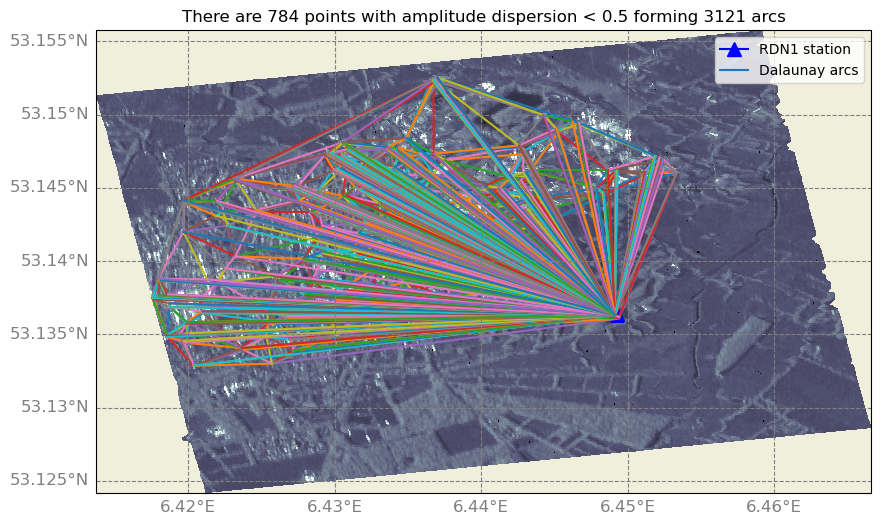

There are 784 points with amplitude dispersion < 0.5 forming 3121 arcs


In [49]:
int_tmpavg = np.mean(np.abs(s1_stack.complex.values)**2,axis=2)
mean0 = np.mean(int_tmpavg)
std0 = np.std(int_tmpavg)

Da, Da_cal = compute_dispersion(s1_stack)

Da_threshold = 0.5

plot_delaunay_arcs(s1_stack, int_tmpavg, Da_cal, Da_threshold, arcs, points, lat_gnss_station, lon_gnss_station, mean0, std0, plot=True, verbose=True)

In [50]:
min_lat = 10e8

for p in points:
    if s1_stack.lat.values[p[0], p[1]] < min_lat:
        min_lat = s1_stack.lat.values[p[0], p[1]]
        p_min_lat = p
print(min_lat, p_min_lat)

53.132854 [69 30]


In [51]:
s1_stack.lat.values[points[0][0], points[0][1]], s1_stack.lon.values[points[0][0], points[0][1]]

(53.133003, 6.4257207)

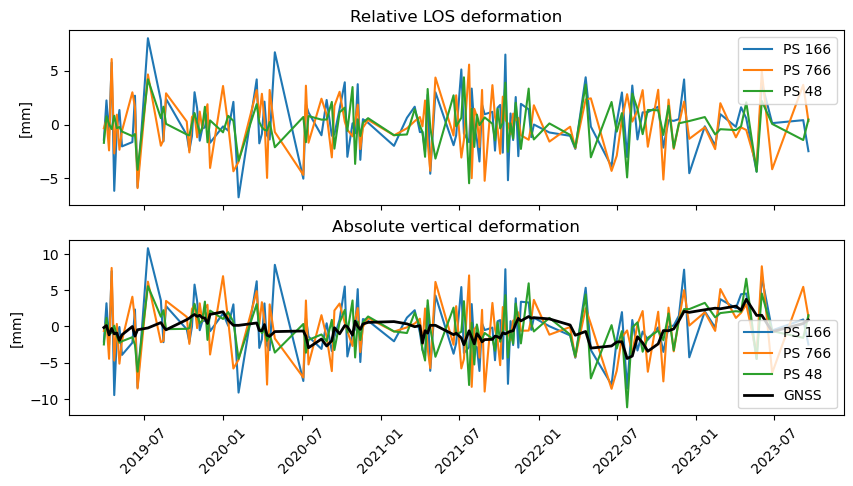

In [101]:

num_samples = 3
sampled_indices = np.random.choice(len(vertical), num_samples, replace=False)

fig, axs = plt.subplots(2,1, figsize=(10, 5), sharex=True)

axs = axs.ravel()

for s in sampled_indices:
    axs[0].plot(time_array_insar, ls_deformation[s], label=f"PS {s}")
    axs[1].plot(time_array_insar, vertical[s] + interpolated_values_up, label=f"PS {s}")

axs[1].plot(time_array_insar, interpolated_values_up, label="GNSS", color="black", linewidth=2)

axs[0].set_title("Relative LOS deformation")
axs[1].set_title("Absolute vertical deformation")
axs[0].set_ylabel("[mm]")
axs[1].set_ylabel("[mm]")
plt.xticks(rotation=45)
axs[0].legend(loc='best')
axs[1].legend(loc='best')

plt.savefig("figures/relative_LOS_and_absolute_deformation.png", dpi=300, bbox_inches='tight')

plt.show()
    
# for n in [10, 100, 200, 500, 1000, 2000, 4000?]:
# plt.plot(time_array_insar, ls_deformation[300])
# 
# plt.plot(time_array_insar, los_deformation_gnss, label="GNSS", color="black", linewidth=2)
# plt.plot(time_array_insar, los_deformation_gnss - 56/2, ':', color="red")
# plt.plot(time_array_insar, los_deformation_gnss + 56/2, ':', color="red")

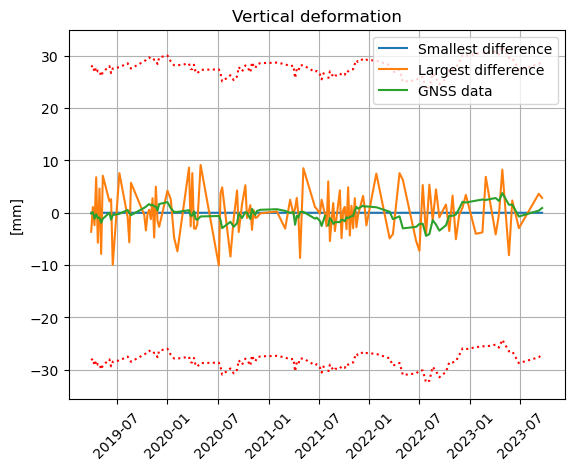

In [ ]:
plt.plot(time_array_insar, vertical[my_I], label="Smallest difference")
plt.plot(time_array_insar, vertical[my_other_I], label="Largest difference")
plt.plot(time_array_insar, interpolated_values_up, label="GNSS data")
plt.plot(time_array_insar, interpolated_values_up + 56/2, ':', color="red")
plt.plot(time_array_insar, interpolated_values_up - 56/2, ':', color="red")
plt.title("Vertical deformation")
plt.xticks(rotation=45)
# plt.ylim(-10, 10)
plt.ylabel("[mm]")
plt.legend()
plt.grid()
plt.show()

In [ ]:
from astropy.timeseries import LombScargle
# Placeholder for storing the deformation arrays that exceed the 5% false alarm threshold
selected_deformations = []

# Iterate over all 505 deformation arrays
for i in range(len(vertical)):
    detrended_data_insar = (vertical[i, :] + interpolated_values_up_no_nan) - np.mean(vertical[i, :] + interpolated_values_up_no_nan)
    
    # Perform Lomb-Scargle periodogram
    LS = LombScargle(time_array_decimal, detrended_data_insar)
    frequency, power = LS.autopower(nyquist_factor=1)
    
    # Calculate levels of false alarm probabilities
    false_alarm_probabilities = [0.05]  # 5% false alarm threshold
    levels = LS.false_alarm_level(false_alarm_probabilities, method='baluev')

    # Check if any power value exceeds the 5% false alarm threshold
    if np.any(power > levels[0]):
        selected_deformations.append(detrended_data_insar)

# Convert the selected deformations to a numpy array for easier handling
selected_deformations = np.array(selected_deformations)

NameError: name 'interpolated_values_up_no_nan' is not defined

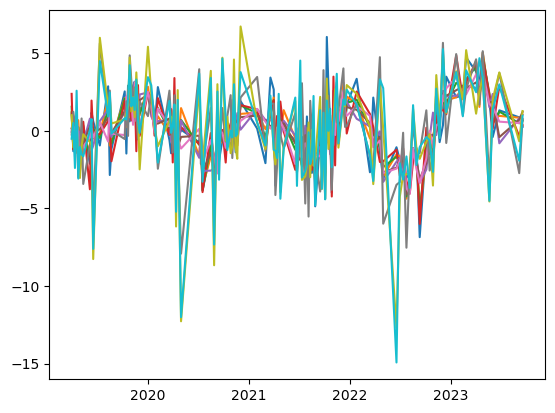

In [ ]:
# plt.plot(time_array_decimal, )
for deformation in selected_deformations:
    plt.plot(time_array_decimal, deformation)

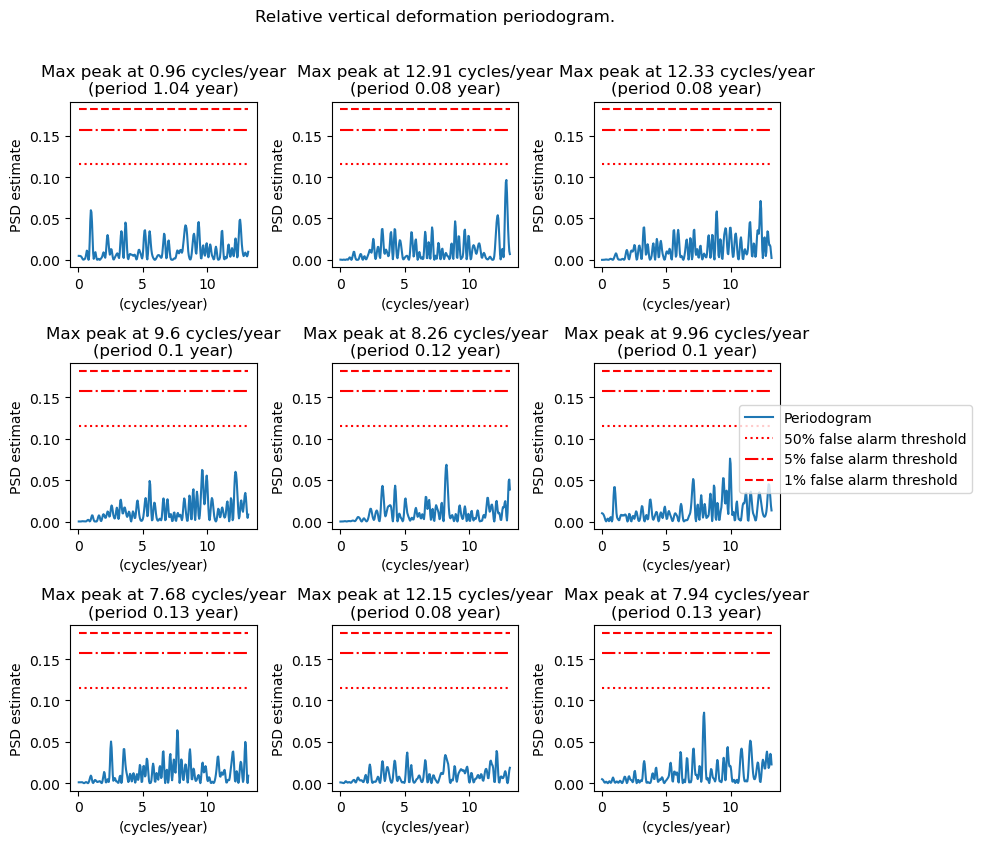

In [132]:
from astropy.timeseries import LombScargle
import matplotlib.pyplot as plt
import numpy as np

# Number of samples, ensuring it's a perfect square
num_samples = 9
sampled_indices = np.random.choice(len(vertical), num_samples, replace=False)

# Calculate the size of the grid (e.g., for 9 samples, it's 3x3)
grid_size = int(np.sqrt(num_samples))

fig, axes = plt.subplots(grid_size, grid_size, figsize=(8, 8))
axes = axes.flatten()
i = 0
for idx, arcn in enumerate(sampled_indices):
    ax = axes[idx]

    LS = LombScargle(time_array_decimal, (vertical[arcn]) - np.mean(vertical[arcn] + interpolated_values_up))
    frequency, power = LS.autopower(nyquist_factor=1)

    ax.plot(frequency, power, label='Periodogram')

    # Calculate levels of false alarm probabilities
    false_alarm_probabilities = [0.5, 0.05, 0.01]
    levels = LS.false_alarm_level(false_alarm_probabilities, method='baluev')

    ax.plot(frequency, levels[0] * np.ones(frequency.shape), 'r:', label='50% false alarm threshold')
    ax.plot(frequency, levels[1] * np.ones(frequency.shape), 'r-.', label='5% false alarm threshold')
    ax.plot(frequency, levels[2] * np.ones(frequency.shape), 'r--', label='1% false alarm threshold')

    freq_max = frequency[power.argmax()]
    period_max = 1 / freq_max

    ax.set_title(f'Max peak at {round(freq_max, 2)} cycles/year\n(period {round(period_max, 2)} year)')
    ax.set_xlabel('(cycles/year)')
    ax.set_ylabel('PSD estimate')
    if i == 0:
        fig.legend(loc='right', bbox_to_anchor=(1.23, 0.5))
        i += 1

fig.tight_layout()
plt.suptitle("Relative vertical deformation periodogram.", y=1.05, x=0.55)
plt.savefig("figures/relative_vertical_def_periodogram.png", dpi=300, bbox_inches='tight')
plt.show()



In [ ]:
data =  pd.DataFrame({
    'Year': epochDyear,
    'Deformations North': obsData[pnum,:,0],
    'Deformations East': obsData[pnum,:,1],
    'Deformations Up': obsData[pnum,:,2]
})

data = data.dropna()

In [ ]:
updisplacements_detrended = scipy.signal.detrend(data['Deformations Up'], axis=-1, type='linear', bp=0, overwrite_data=False)

In [ ]:
idx_nan = np.isnan(interpolated_values_up)

interpolated_values_up_no_nan = interpolated_values_up[~idx_nan]
time_array_decimal_no_nan = time_array_decimal[~idx_nan]


In [ ]:
plt.plot(time_array_decimal_no_nan, interpolated_values_up_no_nan)

NameError: name 'time_array_decimal_no_nan' is not defined

In [ ]:
selected_deformations

[]

In [ ]:
from astropy.timeseries import LombScargle

LS = LombScargle(time_array_decimal_no_nan, sele)

frequency, power = LS.autopower(nyquist_factor=1)
plt.figure(figsize=(10,6))
plt.plot(frequency,power,label='LS periodogram')

# calculate levels of false alarm probabilities
false_alarm_probabilities=[0.5,0.05,0.01]
levels = LS.false_alarm_level(false_alarm_probabilities,method='baluev') # preferred options are "bootstrap" and "baluev", "naive" is unreliable

plt.plot(frequency,levels[0]*np.ones((frequency).shape),'r:',label='50% false alarm threshold')
plt.plot(frequency,levels[1]*np.ones((frequency).shape),'r-.',label='5% false alarm threshold ')
plt.plot(frequency,levels[2]*np.ones((frequency).shape),'r--',label='1% false alarm threshold')

plt.legend()
plt.xlabel('frequency (cycles/year)')
plt.xlim(0,20)
plt.ylabel('normalized periodogram (~ PSD estimate)')


freq_max = frequency[power.argmax()]
plt.title('Lomb-Scargle periodogram of detrended time series, RDN1[North], max peak at period {} year'.format(round(1/freq_max,1)))


NameError: name 'time_array_decimal_no_nan' is not defined

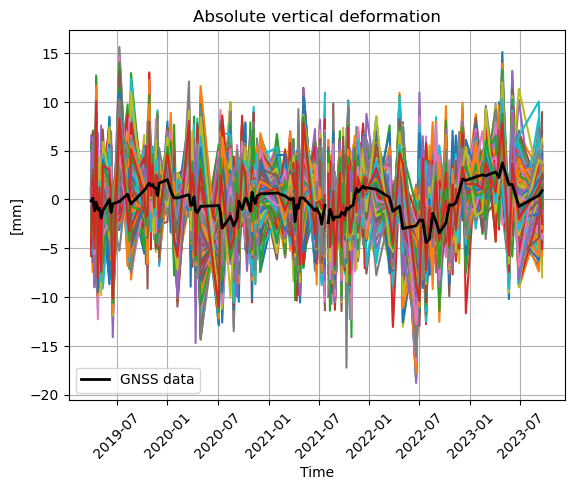

In [ ]:
for v in vertical:
    plt.plot(time_array_insar, v + interpolated_values_up)

plt.plot(time_array_insar, interpolated_values_up, label="GNSS data", color="black", linewidth=2)
# plt.plot(time_array_insar, interpolated_values_up + 56/2, ':', color="red")
# plt.plot(time_array_insar, interpolated_values_up - 56/2, ':', color="red")
plt.xlabel("Time")
plt.xticks(rotation=45)
plt.ylabel("[mm]")
plt.title("Absolute vertical deformation")
plt.legend()
plt.grid()
plt.show()


NameError: name 'good_point_lon' is not defined

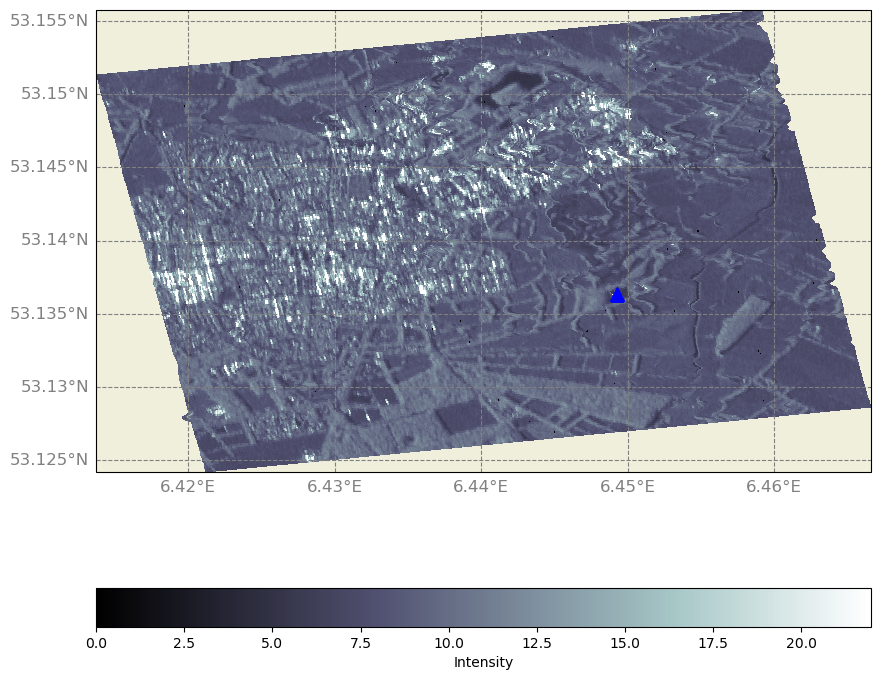

In [ ]:
int_tmpavg = np.mean(np.abs(s1_stack.complex.values)**2,axis=2)

mean0 = np.mean(int_tmpavg)
std0 = np.std(int_tmpavg)


fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 10))

mesh = ax.pcolormesh(s1_stack.lon, s1_stack.lat, int_tmpavg**0.25, transform=ccrs.PlateCarree(), 
                     cmap='bone', vmax=(mean0+1*std0)**0.25)

fig.colorbar(mesh, ax=ax, orientation='horizontal', label='Intensity')

ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)

# Add gridlines and labels
gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), linestyle='--', color='gray')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 12, 'color': 'gray'}
gl.ylabel_style = {'size': 12, 'color': 'gray'}

# Coordinates of the GNSS station

# Add triangle marker at GNSS station position
ax.plot(lon_gnss_station, lat_gnss_station, marker='^', color='blue', markersize=10, transform=ccrs.PlateCarree(), label='RDN1 station')

ax.plot(good_point_lon, good_point_lat, marker='.', color='green', markersize=10, transform=ccrs.PlateCarree(), label='Good point')
ax.plot(bad_point_lon, bad_point_lat, marker='o', color='red', markersize=10, transform=ccrs.PlateCarree(), label='Bad point')

for p in good_points:
    ax.plot(p[1], p[0], marker='.', color='green', markersize=10, transform=ccrs.PlateCarree())

start_date = np.datetime_as_string(s1_stack.time.values[0], unit='M')
end_date = np.datetime_as_string(s1_stack.time.values[-1], unit='M')

plt.title(f"Temporal average intensity image of Groningen between {start_date} and {end_date}")

plt.legend(loc='upper right')

plt.show()

In [ ]:
nan_indices = np.isnan(los_deformation_gnss)
non_nan_indices = np.logical_not(nan_indices)

los_deformation_gnss[nan_indices] = np.interp(np.flatnonzero(nan_indices), np.flatnonzero(non_nan_indices), los_deformation_gnss[non_nan_indices])



In [ ]:
wavelength = 56 # mm
gnss_phase_uw = 4*math.pi * los_deformation_gnss / wavelength

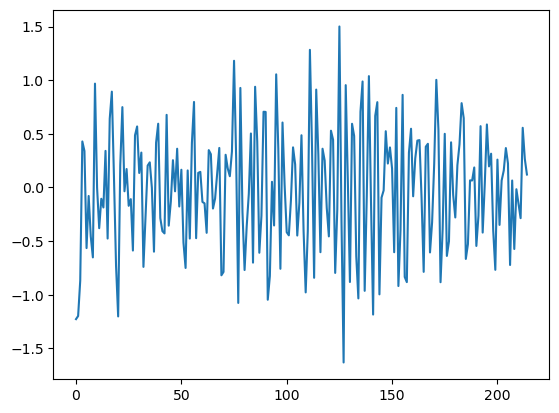

In [ ]:
shitty_phase = ls_phase[my_other_I]

plt.plot(np.gradient(shitty_phase))

In [ ]:
time_array_decimal[-1] - time_array_decimal[0]

4.468493150684935

In [ ]:


np.min(np.gradient(shitty_phase))

NameError: name 'shitty_phase' is not defined

NameError: name 'gnss_phase_uw' is not defined

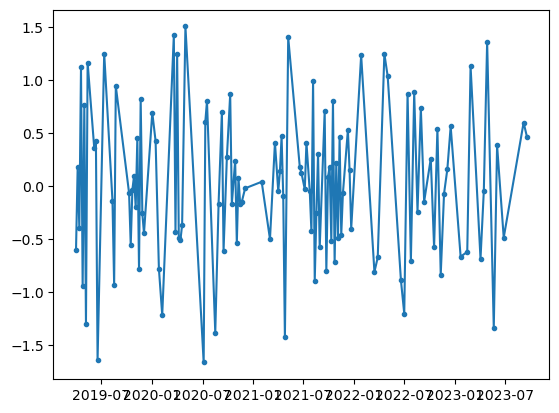

In [ ]:
plt.plot(time_array_insar, ls_phase[my_other_I], marker='.')
plt.plot(time_array_insar, gnss_phase_uw)
plt.scatter(time_array_insar[29], ls_phase[my_other_I][29], color='red', marker='o')

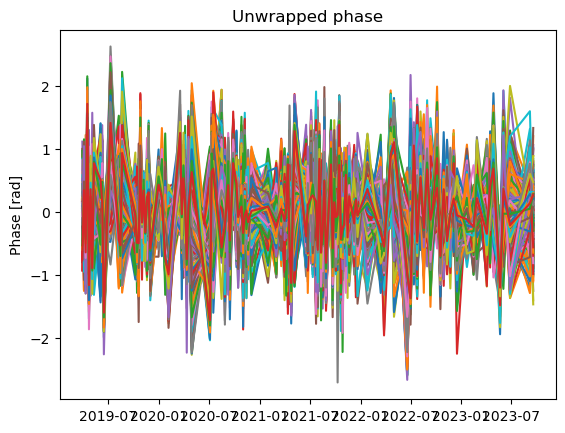

In [ ]:
for phase in ls_phase:
    plt.plot(time_array_insar, phase)

# plt.plot(time_array_insar, gnss_phase_uw, label="GNSS", color="black", linewidth=2)
plt.ylabel("Phase [rad]")
plt.title("Unwrapped phase")
plt.show()


In [ ]:
np.min(np.gradient(ls_phase[14]))

-1.255246863155346

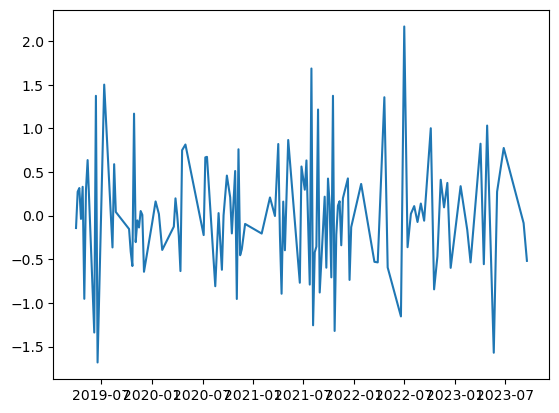

In [ ]:
plt.plot(time_array_insar, ls_phase[14])

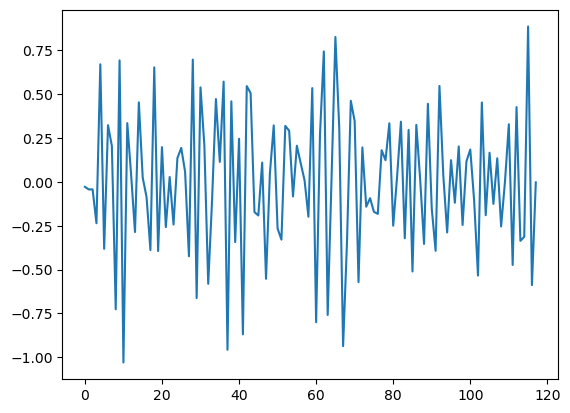

In [ ]:
plt.plot(phase_uw[14])

In [ ]:
np.max(np.gradient(phase_uw[14]))

0.7920395

In [ ]:
# for i, phase in enumerate(phase_uw):
#     if np.max(phase) > 3:
#         print(i)

In [ ]:
interpolated_values_up_no_nan

NameError: name 'interpolated_values_up_no_nan' is not defined